# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
torch.cuda.is_available()

True

# Retrieve dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1 2]


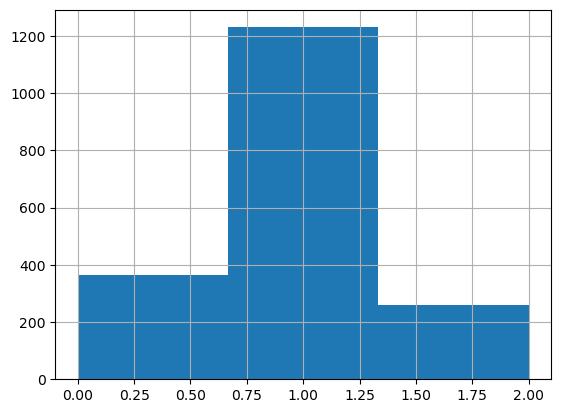

In [2]:
classesList = ['andere','factuur','aanmaning']

Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)
#Dataset = Dataset.drop(Dataset[Dataset['classIndex'] == 0].index,axis=0)
#Dataset.loc[Dataset['classIndex'] == 1, 'classIndex'] = 0
#Dataset.loc[Dataset['classIndex'] == 2, 'classIndex'] = 1
print(Dataset['classIndex'].unique())

### Split dataset into train/test set

In [3]:
trainSet, testSet = train_test_split(Dataset, test_size=0.1, stratify=Dataset['classIndex'], random_state=42)

# Define BERTje model with hyperparameters

In [4]:
cudaAvailable = torch.cuda.is_available()

trainArguments = {'reprocess_input_data' : True, 'num_train_epochs' : 10, 'process_count' : 6, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'per_device_train_batch_size' : 16, 'gradient_accumulation_steps' : 4}
classifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=3,args=trainArguments, use_cuda=True)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

### Start training the model

In [5]:
classifier.train_model(trainSet)

C:\Users\kerseje\AppData\Local\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/209 [00:00<?, ?it/s]

(520, 0.1483572696356602)

### Evaluate the resulting model against test set

In [6]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\kerseje\AppData\Local\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

{'mcc': 0.7173683108719444, 'f1': 0.8602150537634409, 'confusionMatrix': array([[ 30,   6,   1],
       [  5, 115,   3],
       [  5,   6,  15]], dtype=int64), 'eval_loss': 0.7999435042341551}


### Save model localy

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on.

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one